# Edge-Aware GNN + LSTM for Multi-Variable Ocean Forecasting

### This pipeline preprocesses satellite-derived oceanographic data, scales features, and constructs a spatial graph where edges encode geodesic distance and temporal correlation (PC1-based PCC). An edge-aware Graph Neural Network (NNConv layers) extracts spatial dependencies, while an LSTM captures temporal patterns across sequences. Unlike Liang et al. (2023), A Graph Memory Neural Network for Sea Surface Temperature Prediction, which focuses on single-variable SST prediction using GMNN with a memory module, our model predicts 8 variables simultaneously without a memory module, leveraging learned edge features and a lighter architecture for faster training. Performance is evaluated grid-wise and globally using SMAPE, RMSE, and MAE heatmaps.

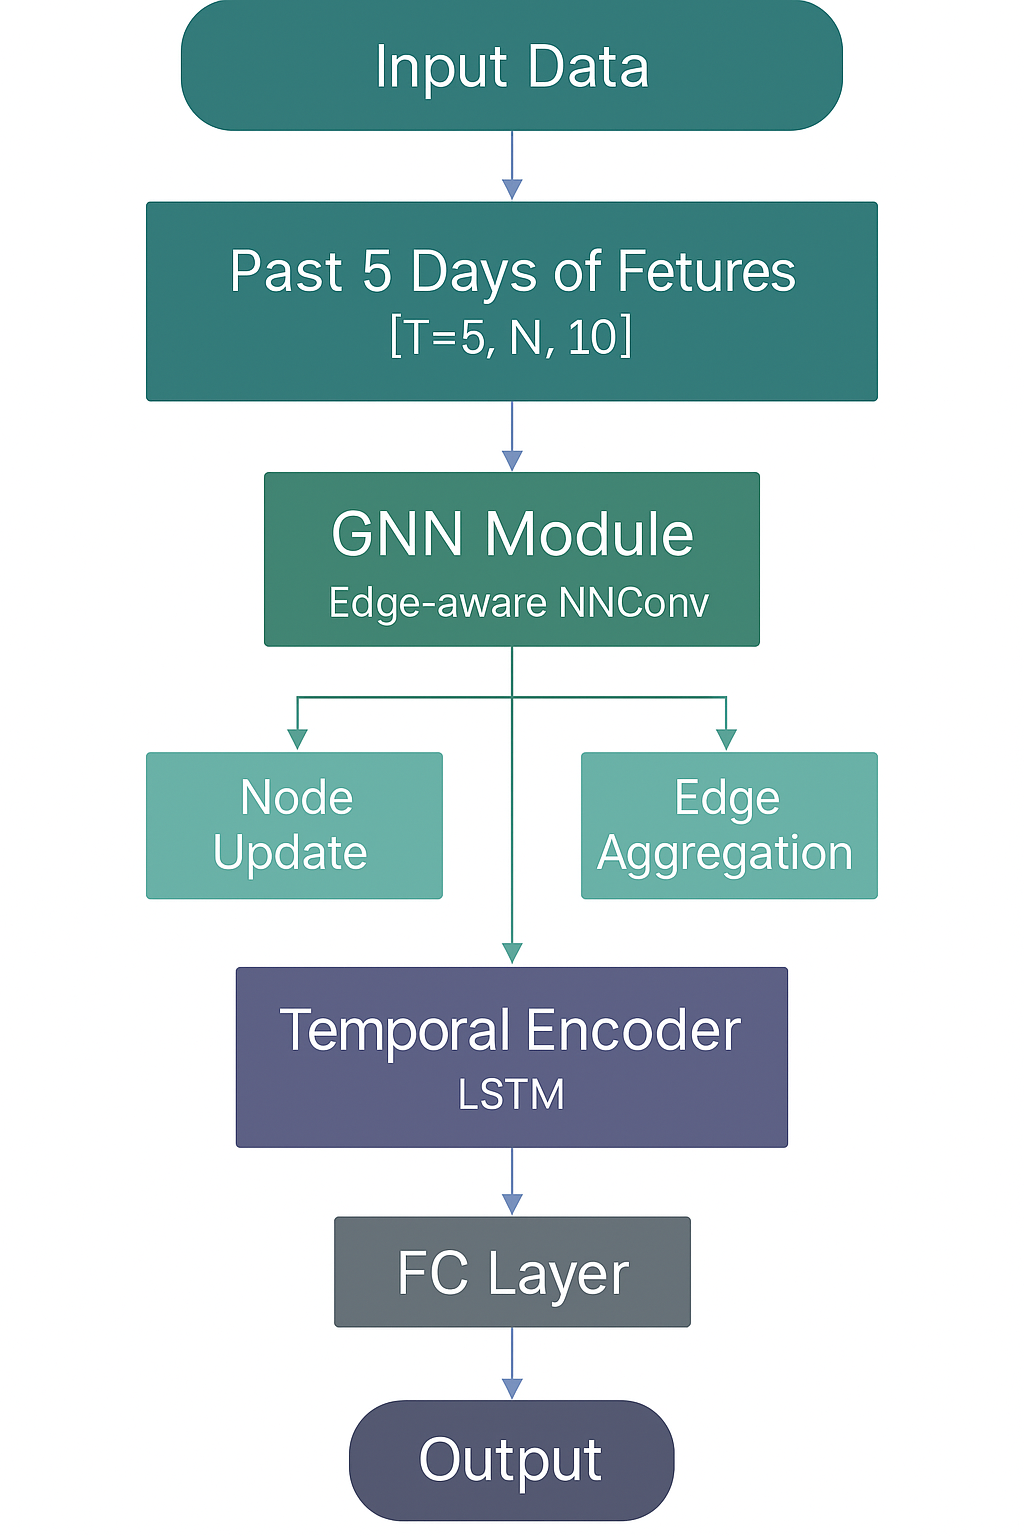

In [ ]:
from IPython.display import Image, display
display(Image(filename='flowchart_gnmm.png', width=300))

In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import NNConv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import BallTree
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns



# Helper: geodesic distance (km) and bearing (deg from North)


### They let the model encode spatial relationships between nodes by using real-world distances and directions as edge features in the graph.


In [ ]:

EARTH_R_KM = 6371.0088

def haversine_km(lat1, lon1, lat2, lon2):
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi  = np.radians(lat2 - lat1)
    dlamb = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlamb/2)**2
    return 2 * EARTH_R_KM * np.arcsin(np.sqrt(a))

def bearing_deg(lat1, lon1, lat2, lon2):
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dlamb = np.radians(lon2 - lon1)
    x = np.sin(dlamb) * np.cos(phi2)
    y = np.cos(phi1)*np.sin(phi2) - np.sin(phi1)*np.cos(phi2)*np.cos(dlamb
    )
    brng = np.degrees(np.arctan2(x, y))
    return (brng + 360.0) % 360.0


# load and clean

In [ ]:

df = pd.read_parquet("5km_resolution_with_missing_data_handled_2022_to_2025.parquet")
df = df[df["flags"] == 0]
df.replace(-2.0, np.nan, inplace=True)
df.dropna(inplace=True)

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "lat_5km", "lon_5km"]).reset_index(drop=True)

# Node index
coords = df[["lat_5km", "lon_5km"]].drop_duplicates().reset_index(drop=True)
coords["node_id"] = np.arange(len(coords))
df = df.merge(coords, on=["lat_5km", "lon_5km"], how="left")

# Splits

In [ ]:

dates_all = np.array(sorted(df["date"].unique()))
train_mask = (dates_all.astype("datetime64[D]") >= np.datetime64("2022-01-01")) & \
             (dates_all.astype("datetime64[D]") <= np.datetime64("2023-12-31"))

val_mask = (dates_all.astype("datetime64[D]") >= np.datetime64("2024-01-01")) & \
           (dates_all.astype("datetime64[D]") <= np.datetime64("2024-07-31"))

train_dates = dates_all[train_mask]
val_dates   = dates_all[val_mask]

features = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']
feat_plus_coords = features + ["lon_5km", "lat_5km"]  # add coords as node features

# Fit scaler on TRAIN only, then transform all

In [ ]:

scaler = StandardScaler()
fit_df = df[df["date"].isin(train_dates)].copy()
# Fit directly on DataFrame to avoid the feature-name warning
fit_mat_df = fit_df.sort_values(["date", "node_id"])[feat_plus_coords]
scaler.fit(fit_mat_df)

# Apply scaler to full df (features + coords)
for col in ["lon_5km", "lat_5km"]:
    df[col] = df[col].astype(float)
df[feat_plus_coords] = scaler.transform(df[feat_plus_coords])

# Build tensors per date (node features include coords)

### It converts each day’s data into a fixed node-ordered feature tensor so the model can process daily graph inputs consistently for training and validation.


In [ ]:

N = len(coords)
def day_matrix(day):
    g = df[df["date"] == day].sort_values("node_id")
    X = g[feat_plus_coords].values  # [N, 10]
    return torch.tensor(X, dtype=torch.float)

train_x = [day_matrix(d) for d in train_dates]
val_x   = [day_matrix(d) for d in val_dates]

# PCA(PC1) on TRAIN to get a univariate series per node for PCC (vars only)

### It extracts daily variable values and uses PCA to compute each node’s first principal component over time for correlation-based graph construction.


In [ ]:

def day_matrix_vars(day):
    g = df[df["date"] == day].sort_values("node_id")
    return g[features].values  # [N, 8]

train_stack_vars = np.vstack([day_matrix_vars(d) for d in train_dates])  # [T_train*N, 8]
pca = PCA(n_components=1)
pca.fit(train_stack_vars)  # global PCA on standardized vars

T_train = len(train_dates)
pc1_train = np.zeros((T_train, N), dtype=np.float32)
for ti, d in enumerate(train_dates):
    Xd = day_matrix_vars(d)  # [N, 8]
    pc1_train[ti] = pca.transform(Xd).flatten()

# Build graph FROM TRAIN ONLY: distance + |PCC(PC1)| ≥ r_min

### This code builds the training graph by connecting nearby nodes (within r_min = 7.5 km) that also have a strong correlation in their first principal component time series, then stores each edge’s direction and distance.

### These distance and bearing values are normalized and used as edge features so the GNN can learn spatial patterns between connected locations.

In [ ]:
radius_km = 7.5   # ≈ 1.5 * 5 km grid
r_min = 0.8

# Use RAW coords (degrees) for geometry
coords_raw = df[["node_id", "lat_5km", "lon_5km"]].drop_duplicates().sort_values("node_id").reset_index(drop=True)
lat_deg_raw = coords_raw["lat_5km"].values
lon_deg_raw = coords_raw["lon_5km"].values
X_rad = np.c_[np.radians(lat_deg_raw), np.radians(lon_deg_raw)]

tree = BallTree(X_rad, metric="haversine")
radius_rad = radius_km / EARTH_R_KM

neighbors = tree.query_radius(X_rad, r=radius_rad, return_distance=False)

edge_i, edge_j, edge_attr_list = [], [], []
print("Building train graph with distance+PCC (PC1)...")
for i in tqdm(range(N)):
    cand = neighbors[i]
    cand = cand[cand != i]
    if cand.size == 0:
        continue

    xi = pc1_train[:, i]
    xi_mean = xi.mean()
    xi_std = xi.std() + 1e-8
    for j in cand:
        xj = pc1_train[:, j]
        num = np.dot(xi - xi_mean, xj - xj.mean())
        den = (T_train - 1) * xi_std * (xj.std() + 1e-8)
        r = num / (den + 1e-12)

        if abs(r) >= r_min:
            dist_km = haversine_km(lat_deg_raw[i], lon_deg_raw[i], lat_deg_raw[j], lon_deg_raw[j])
            brg_deg = bearing_deg(lat_deg_raw[i], lon_deg_raw[i], lat_deg_raw[j], lon_deg_raw[j])
            edge_i.append(i); edge_j.append(j)
            edge_attr_list.append([brg_deg, dist_km])

edge_index = torch.tensor(np.vstack([edge_i, edge_j]), dtype=torch.long)      # [2, E]
edge_attr  = torch.tensor(np.array(edge_attr_list, dtype=np.float32))         # [E, 2]
print(f"Graph built. Nodes: {N}, Edges: {edge_index.shape[1]}")

# Normalize edge_attr
edge_attr_mean = edge_attr.mean(dim=0, keepdim=True)
edge_attr_std  = edge_attr.std(dim=0, keepdim=True) + 1e-6
edge_attr_norm = (edge_attr - edge_attr_mean) / edge_attr_std

Building train graph with distance+PCC (PC1)...


100%|██████████| 8544/8544 [00:02<00:00, 3193.35it/s]

Graph built. Nodes: 8544, Edges: 92556


In [ ]:
# edge_index is a [2, E] tensor — first row: source, second row: target
connected_nodes = set(edge_index[0].tolist()) | set(edge_index[1].tolist())

# All possible nodes (0 to N-1)
all_nodes = set(range(N))

# Isolated nodes = those not present in edge_index
isolated_nodes = all_nodes - connected_nodes

print(f"Total nodes: {N}")
print(f"Connected nodes: {len(connected_nodes)}")
print(f"Isolated nodes: {len(isolated_nodes)}")
print(f"Percentage isolated: {100 * len(isolated_nodes) / N:.2f}%")


Total nodes: 8544
Connected nodes: 8510
Isolated nodes: 34
Percentage isolated: 0.40%


##### It shows the constructed training graph has 8,544 nodes with 92,556 edges, where only 0.4% of nodes are isolated (no connections).


# Edge-aware GNN + LSTM (1-step)

### This class defines a spatio-temporal model that first uses edge-aware graph convolutions (`NNConv`) to combine node features with information from neighboring nodes based on bearing and distance, then feeds the resulting embeddings through an LSTM to capture temporal patterns.

### The final linear layer outputs next-step predictions for each node’s variables.


In [ ]:

class EdgeAwareLSTM_Onestep(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_hidden, output_dim, mlp_hidden=16, num_iters=2):
        super().__init__()
        assert num_iters >= 1, "num_iters must be >= 1"
        self.num_iters = num_iters

        self.edge_mlp1 = nn.Sequential(
            nn.Linear(2, mlp_hidden), nn.ReLU(),
            nn.Linear(mlp_hidden, input_dim * hidden_dim)
        )
        self.nnconv1 = NNConv(input_dim, hidden_dim, self.edge_mlp1, aggr='add')

        self.edge_mlp2 = nn.Sequential(
            nn.Linear(2, mlp_hidden), nn.ReLU(),
            nn.Linear(mlp_hidden, hidden_dim * hidden_dim)
        )
        self.nnconv2 = NNConv(hidden_dim, hidden_dim, self.edge_mlp2, aggr='add')

        self.lstm = nn.LSTM(hidden_dim, lstm_hidden, batch_first=True)
        self.fc   = nn.Linear(lstm_hidden, output_dim)

    def forward(self, x_seq, edge_index, edge_attr):
        """
        x_seq:      [T, N, input_dim]
        edge_index: [2, E]
        edge_attr:  [E, 2]  (bearing, distance)  (normalized)
        """
        T, N, _ = x_seq.shape
        outs = []
        for t in range(T):
            h = x_seq[t]                          # [N, input_dim]
            # First pass: input_dim -> H -> H
            h = self.nnconv1(h, edge_index, edge_attr); h = F.relu(h)
            h = self.nnconv2(h, edge_index, edge_attr); h = F.relu(h)
            # Extra iterations: H -> H
            for _ in range(self.num_iters - 1):
                h = self.nnconv2(h, edge_index, edge_attr); h = F.relu(h)
            outs.append(h.unsqueeze(0))           # [1, N, H]

        gseq = torch.cat(outs, dim=0)             # [T, N, H]
        gseq = gseq.permute(1, 0, 2)              # [N, T, H]
        lstm_out, _ = self.lstm(gseq)             # [N, T, L]
        last = lstm_out[:, -1, :]                 # [N, L]
        y = self.fc(last)                         # [N, output_dim]
        return y



# Training setup (MSE, 1-day ahead)

#### This part sets up the model and trains it: it takes the last 5 days of data for every location, uses the GNN + LSTM to predict the next day’s 8 variables, compares the prediction with the actual values, and using MSE loss and Adam optimization to update weights over 20 epochs.


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim   = len(feat_plus_coords)     # 8 + 2 = 10
hidden_dim  = 16
lstm_hidden = 16
output_dim  = len(features)             # predict 8 vars
seq_len     = 5
epochs      = 20
lr          = 1e-3

model = EdgeAwareLSTM_Onestep(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    lstm_hidden=lstm_hidden,
    output_dim=output_dim,
    mlp_hidden=16,
    num_iters=2,           # set 3 to mimic paper; 2 is faster
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn   = nn.MSELoss()

edge_index_dev = edge_index.to(device)
edge_attr_dev  = edge_attr_norm.to(device)

print("Training Edge-aware GNN + LSTM (1-day forecast)...")
for epoch in trange(epochs, desc="Epochs"):
    model.train()
    total_loss, denom = 0.0, 0
    for t in tqdm(range(seq_len, len(train_x)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x_seq = torch.stack(train_x[t-seq_len:t]).to(device)   # [seq, N, 10]
        y_true = train_x[t][:, :len(features)].to(device)      # [N, 8]

        optimizer.zero_grad()
        y_pred = model(x_seq, edge_index_dev, edge_attr_dev)   # [N, 8]
        loss = loss_fn(y_pred, y_true)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        denom += 1
    print(f"Epoch {epoch+1}/{epochs} | Train MSE: {total_loss / max(1,denom):.6f}")


Training Edge-aware GNN + LSTM (1-day forecast)...


Epochs:   5%|▌         | 1/20 [04:05<1:17:37, 245.15s/it]

Epoch 1/20 | Train MSE: 0.579754


Epochs:  10%|█         | 2/20 [08:10<1:13:30, 245.01s/it]

Epoch 2/20 | Train MSE: 0.419755


Epochs:  15%|█▌        | 3/20 [12:14<1:09:19, 244.67s/it]

Epoch 3/20 | Train MSE: 0.383977


Epochs:  20%|██        | 4/20 [16:14<1:04:47, 242.99s/it]

Epoch 4/20 | Train MSE: 0.372374


Epochs:  25%|██▌       | 5/20 [20:15<1:00:35, 242.34s/it]

Epoch 5/20 | Train MSE: 0.365527


Epochs:  30%|███       | 6/20 [24:16<56:23, 241.65s/it]  

Epoch 6/20 | Train MSE: 0.355705


Epochs:  35%|███▌      | 7/20 [28:16<52:14, 241.14s/it]

Epoch 7/20 | Train MSE: 0.348860


Epochs:  40%|████      | 8/20 [32:20<48:23, 241.95s/it]

Epoch 8/20 | Train MSE: 0.345807


Epochs:  45%|████▌     | 9/20 [36:23<44:26, 242.44s/it]

Epoch 9/20 | Train MSE: 0.343153


Epochs:  50%|█████     | 10/20 [40:28<40:32, 243.28s/it]

Epoch 10/20 | Train MSE: 0.339568


Epochs:  55%|█████▌    | 11/20 [44:32<36:31, 243.45s/it]

Epoch 11/20 | Train MSE: 0.340296


Epochs:  60%|██████    | 12/20 [48:37<32:32, 244.04s/it]

Epoch 12/20 | Train MSE: 0.339186


Epochs:  65%|██████▌   | 13/20 [52:41<28:26, 243.76s/it]

Epoch 13/20 | Train MSE: 0.338881


Epochs:  70%|███████   | 14/20 [56:46<24:26, 244.40s/it]

Epoch 14/20 | Train MSE: 0.336842


Epochs:  75%|███████▌  | 15/20 [1:00:52<20:23, 244.75s/it]

Epoch 15/20 | Train MSE: 0.337681


Epochs:  80%|████████  | 16/20 [1:04:59<16:21, 245.38s/it]

Epoch 16/20 | Train MSE: 0.340716


Epochs:  85%|████████▌ | 17/20 [1:09:11<12:22, 247.43s/it]

Epoch 17/20 | Train MSE: 0.338379


Epochs:  90%|█████████ | 18/20 [1:13:17<08:14, 247.14s/it]

Epoch 18/20 | Train MSE: 0.344134


Epochs:  95%|█████████▌| 19/20 [1:17:23<04:06, 246.57s/it]

Epoch 19/20 | Train MSE: 0.336365


Epochs: 100%|██████████| 20/20 [1:21:25<00:00, 244.25s/it]

Epoch 20/20 | Train MSE: 0.333937


# validation

### Runs the model on the validation set to get predictions for each node and date. Converts predictions and targets back to the original scale. Computes per-node MSE, MAE, and SMAPE, then saves them with coordinates.


In [ ]:

# Collect all predictions and targets (grid-wise)

model.eval()
val_preds, val_targets = [], []
with torch.no_grad():
    for t in range(seq_len, len(val_x)):
        x_seq = torch.stack(val_x[t-seq_len:t]).to(device)     # [seq, N, 10]
        y_true = val_x[t][:, :len(features)].to(device)        # [N, 8]
        y_pred = model(x_seq, edge_index_dev, edge_attr_dev)   # [N, 8]
        val_preds.append(y_pred.cpu().numpy())
        val_targets.append(y_true.cpu().numpy())

val_pred_arr = np.stack(val_preds)   # [T_val', N, 8]
val_true_arr = np.stack(val_targets)


# Unstandardize (only for the 8 vars)

Tval, Nnodes, Fvars = val_pred_arr.shape
pad_zeros = np.zeros((Tval*Nnodes, 2), dtype=np.float32)
pred_flat10 = np.hstack([val_pred_arr.reshape(-1, Fvars), pad_zeros])
true_flat10 = np.hstack([val_true_arr.reshape(-1, Fvars), pad_zeros])

pred_unscaled10 = scaler.inverse_transform(pred_flat10)
true_unscaled10 = scaler.inverse_transform(true_flat10)

val_pred_unscaled = pred_unscaled10[:, :Fvars].reshape(Tval, Nnodes, Fvars)
val_true_unscaled = true_unscaled10[:, :Fvars].reshape(Tval, Nnodes, Fvars)

# Compute metrics per grid point (across all validation dates)

eps = 1e-8
mse_grid = np.mean((val_pred_unscaled - val_true_unscaled)**2, axis=0)  # [N, F]
mae_grid = np.mean(np.abs(val_pred_unscaled - val_true_unscaled), axis=0)
smape_grid = 100 * np.mean(
    np.abs(val_pred_unscaled - val_true_unscaled) /
    (np.abs(val_pred_unscaled) + np.abs(val_true_unscaled) + eps),
    axis=0
)


# Save with lat/lon for each grid point

coords_ordered = coords_raw.sort_values("node_id")[["node_id", "lat_5km", "lon_5km"]].reset_index(drop=True)
mse_df   = pd.concat([coords_ordered, pd.DataFrame(mse_grid,   columns=features)], axis=1)
mae_df   = pd.concat([coords_ordered, pd.DataFrame(mae_grid,   columns=features)], axis=1)
smape_df = pd.concat([coords_ordered, pd.DataFrame(smape_grid, columns=features)], axis=1)

mse_df.to_parquet("gridwise_mse.parquet", index=False)
mae_df.to_parquet("gridwise_mae.parquet", index=False)
smape_df.to_parquet("gridwise_smape.parquet", index=False)

print("Saved: gridwise_mse.parquet, gridwise_mae.parquet, gridwise_smape.parquet")


Saved: gridwise_mse.parquet, gridwise_mae.parquet, gridwise_smape.parquet


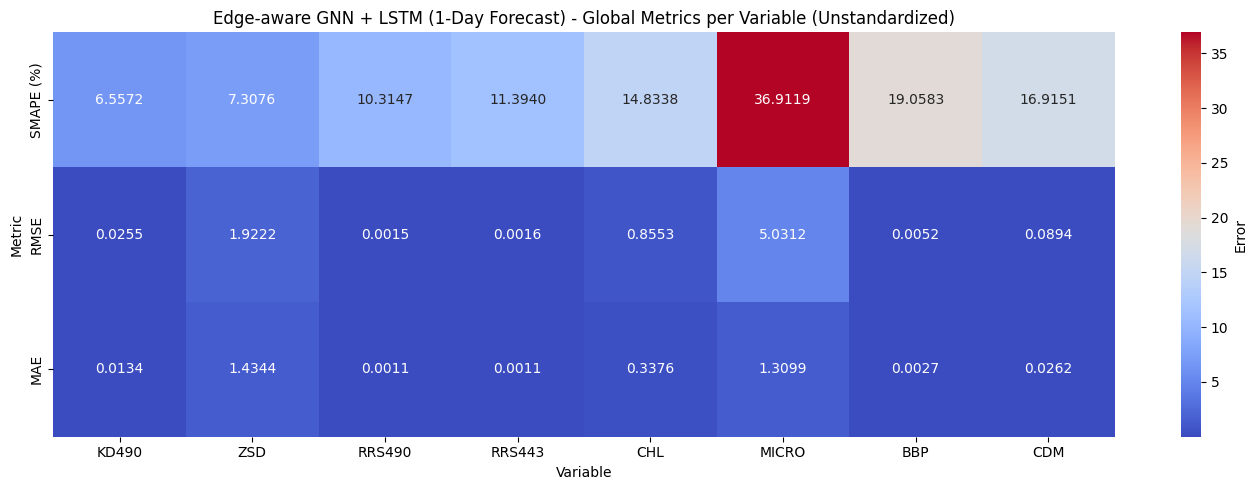

In [ ]:

# Global metrics

eps = 1e-8
smape = 100 * np.mean(
    np.abs(val_pred_unscaled - val_true_unscaled) /
    (np.abs(val_pred_unscaled) + np.abs(val_true_unscaled) + eps),
    axis=(0, 1)
)
rmse = np.sqrt(np.mean((val_pred_unscaled - val_true_unscaled) ** 2, axis=(0, 1)))
mae  = np.mean(np.abs(val_pred_unscaled - val_true_unscaled), axis=(0, 1))


# Build DataFrame

metrics_df = pd.DataFrame({
    'SMAPE (%)': smape,
    'RMSE': rmse,
    'MAE': mae
}, index=features).T  # transpose to match your heatmap format


# Plot heatmap

plt.figure(figsize=(14,5))
sns.heatmap(metrics_df, annot=True, fmt=".4f", cmap="coolwarm", cbar_kws={'label': 'Error'})
plt.title("Edge-aware GNN + LSTM (1-Day Forecast) - Global Metrics per Variable (Unstandardized)")
plt.xlabel("Variable")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()


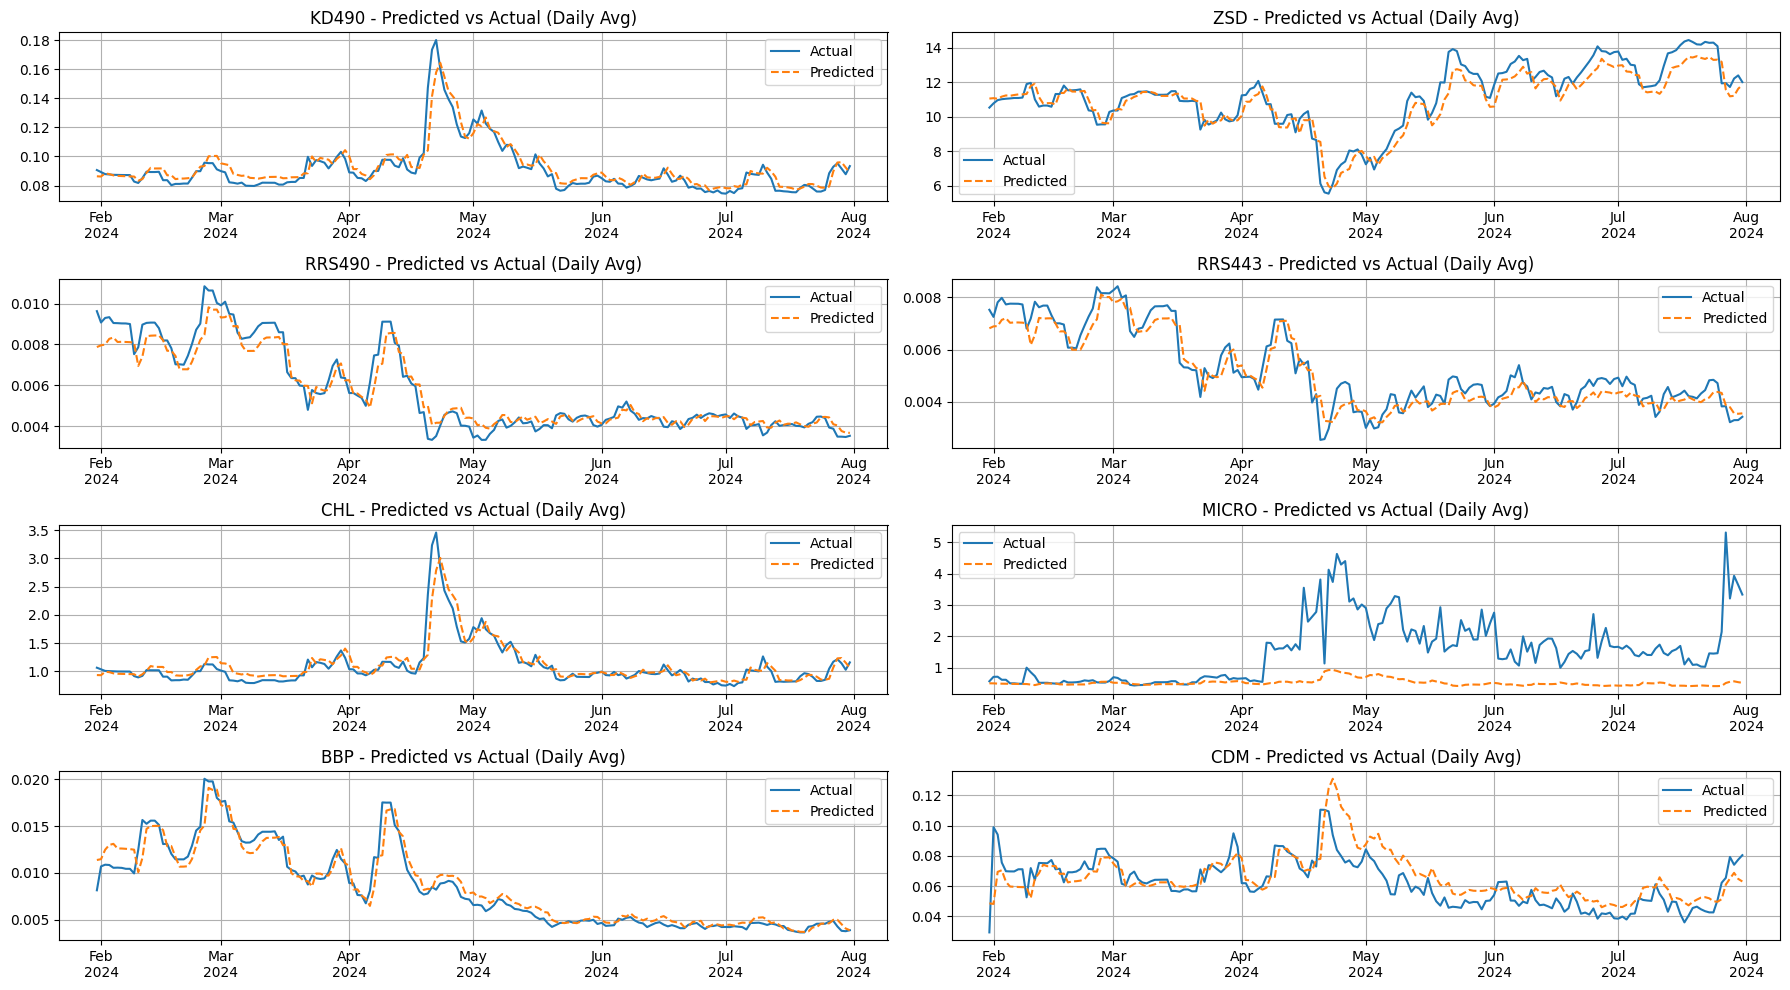

In [ ]:

# Daily spatial means plot

pred_means = val_pred_unscaled.mean(axis=1)  # [Tval, F]
true_means = val_true_unscaled.mean(axis=1)
val_dates_seq = val_dates[seq_len: seq_len + len(pred_means)]

import matplotlib.dates as mdates
fig, axs = plt.subplots(4, 2, figsize=(18, 10)); axs = axs.flatten()
for i, var in enumerate(features):
    axs[i].plot(val_dates_seq, true_means[:, i], label="Actual")
    axs[i].plot(val_dates_seq, pred_means[:, i], label="Predicted", linestyle="--")
    axs[i].set_title(f"{var} - Predicted vs Actual (Daily Avg)")
    axs[i].xaxis.set_major_locator(mdates.MonthLocator())
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axs[i].grid(True); axs[i].legend()
plt.tight_layout(); plt.show()

# Saving Everything in One Checkpoint

In [ ]:
import joblib

checkpoint_path = "gmnn_full_checkpoint.pth"

# Build a dictionary with everything we need
checkpoint = {
    "model_state_dict": model.state_dict(),
    "scaler": scaler,  # sklearn scaler object
    "edge_index": edge_index.cpu(),
    "edge_attr_norm": edge_attr_norm.cpu(),
    "features": features,
    "feat_plus_coords": feat_plus_coords,
    "coords_raw": coords_raw,  # includes node_id, lat, lon
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "lstm_hidden": lstm_hidden,
    "output_dim": output_dim,
    "mlp_hidden": 16,
    "num_iters": 2,
    "seq_len": seq_len
}

# Save with torch (joblib could be used, but torch handles tensors well)
torch.save(checkpoint, checkpoint_path)
print(f"Full model + preprocessing saved to {checkpoint_path}")


Full model + preprocessing saved to gmnn_full_checkpoint.pth


### Loading Everything Model, scaler, and graph restored. Ready for New Data on same location

In [ ]:
# # Load the checkpoint
# checkpoint = torch.load("gmnn_full_checkpoint.pth", map_location=device)

# # Rebuild the model with same architecture
# model = EdgeAwareLSTM_Onestep(
#     input_dim=checkpoint["input_dim"],
#     hidden_dim=checkpoint["hidden_dim"],
#     lstm_hidden=checkpoint["lstm_hidden"],
#     output_dim=checkpoint["output_dim"],
#     mlp_hidden=checkpoint["mlp_hidden"],
#     num_iters=checkpoint["num_iters"]
# ).to(device)

# # Load weights
# model.load_state_dict(checkpoint["model_state_dict"])
# model.eval()

# # Restore preprocessing + graph
# scaler = checkpoint["scaler"]
# edge_index = checkpoint["edge_index"].to(device)
# edge_attr_norm = checkpoint["edge_attr_norm"].to(device)
# features = checkpoint["features"]
# feat_plus_coords = checkpoint["feat_plus_coords"]
# coords_raw = checkpoint["coords_raw"]

# seq_len = checkpoint["seq_len"]

# print(" Model, scaler, and graph restored. Ready for New Data on same location")


# Testing

Saved: gridwise_mse_TEST.parquet, gridwise_mae_TEST.parquet, gridwise_smape_TEST.parquet


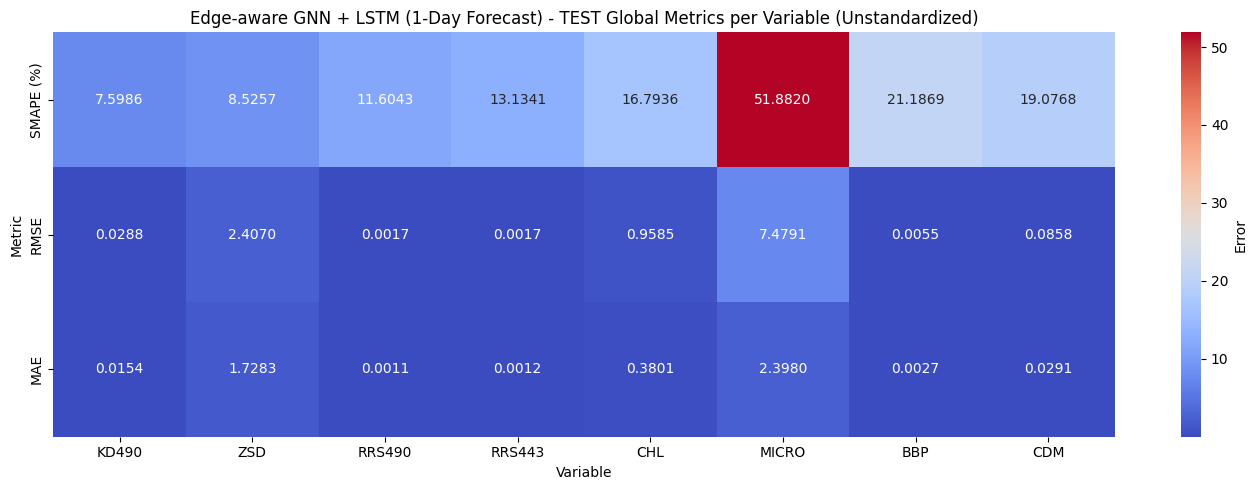

In [ ]:

# TEST split (recent most 12 months)

test_mask = (dates_all.astype("datetime64[D]") >= np.datetime64("2024-08-01")) & \
            (dates_all.astype("datetime64[D]") <= np.datetime64("2025-07-31"))
test_dates = dates_all[test_mask]


test_x = [day_matrix(d) for d in test_dates]



model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for t in range(seq_len, len(test_x)):
        x_seq = torch.stack(test_x[t-seq_len:t]).to(device)      # [seq, N, 10]
        y_true = test_x[t][:, :len(features)].to(device)         # [N, 8]
        y_pred = model(x_seq, edge_index_dev, edge_attr_dev)     # [N, 8]
        test_preds.append(y_pred.cpu().numpy())
        test_targets.append(y_true.cpu().numpy())

test_pred_arr = np.stack(test_preds)    # [T_test', N, 8]
test_true_arr = np.stack(test_targets)  # [T_test', N, 8]

# Unstandardize (only the 8 vars)

Tt, Nn, Fv = test_pred_arr.shape
pad_zeros = np.zeros((Tt*Nn, 2), dtype=np.float32)
test_pred_flat10 = np.hstack([test_pred_arr.reshape(-1, Fv), pad_zeros])
test_true_flat10 = np.hstack([test_true_arr.reshape(-1, Fv), pad_zeros])

test_pred_unscaled10 = scaler.inverse_transform(test_pred_flat10)
test_true_unscaled10 = scaler.inverse_transform(test_true_flat10)

test_pred_unscaled = test_pred_unscaled10[:, :Fv].reshape(Tt, Nn, Fv)
test_true_unscaled = test_true_unscaled10[:, :Fv].reshape(Tt, Nn, Fv)


# Gridwise metrics over TEST

eps = 1e-8
mse_grid_test = np.mean((test_pred_unscaled - test_true_unscaled)**2, axis=0)         # [N, F]
mae_grid_test = np.mean(np.abs(test_pred_unscaled - test_true_unscaled), axis=0)      # [N, F]
smape_grid_test = 100 * np.mean(
    np.abs(test_pred_unscaled - test_true_unscaled) /
    (np.abs(test_pred_unscaled) + np.abs(test_true_unscaled) + eps),
    axis=0
)

coords_ordered = coords_raw.sort_values("node_id")[["node_id", "lat_5km", "lon_5km"]].reset_index(drop=True)
mse_df_test   = pd.concat([coords_ordered, pd.DataFrame(mse_grid_test,   columns=features)], axis=1)
mae_df_test   = pd.concat([coords_ordered, pd.DataFrame(mae_grid_test,   columns=features)], axis=1)
smape_df_test = pd.concat([coords_ordered, pd.DataFrame(smape_grid_test, columns=features)], axis=1)

mse_df_test.to_parquet("gridwise_mse_TEST.parquet", index=False)
mae_df_test.to_parquet("gridwise_mae_TEST.parquet", index=False)
smape_df_test.to_parquet("gridwise_smape_TEST.parquet", index=False)
print("Saved: gridwise_mse_TEST.parquet, gridwise_mae_TEST.parquet, gridwise_smape_TEST.parquet")


# Global TEST metrics + heatmap

smape_test = 100 * np.mean(
    np.abs(test_pred_unscaled - test_true_unscaled) /
    (np.abs(test_pred_unscaled) + np.abs(test_true_unscaled) + eps),
    axis=(0, 1)
)
rmse_test = np.sqrt(np.mean((test_pred_unscaled - test_true_unscaled) ** 2, axis=(0, 1)))
mae_test  = np.mean(np.abs(test_pred_unscaled - test_true_unscaled), axis=(0, 1))

metrics_df_test = pd.DataFrame({
    'SMAPE (%)': smape_test,
    'RMSE': rmse_test,
    'MAE': mae_test
}, index=features).T

plt.figure(figsize=(14,5))
sns.heatmap(metrics_df_test, annot=True, fmt=".4f", cmap="coolwarm", cbar_kws={'label': 'Error'})
plt.title("Edge-aware GNN + LSTM (1-Day Forecast) - TEST Global Metrics per Variable (Unstandardized)")
plt.xlabel("Variable")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()


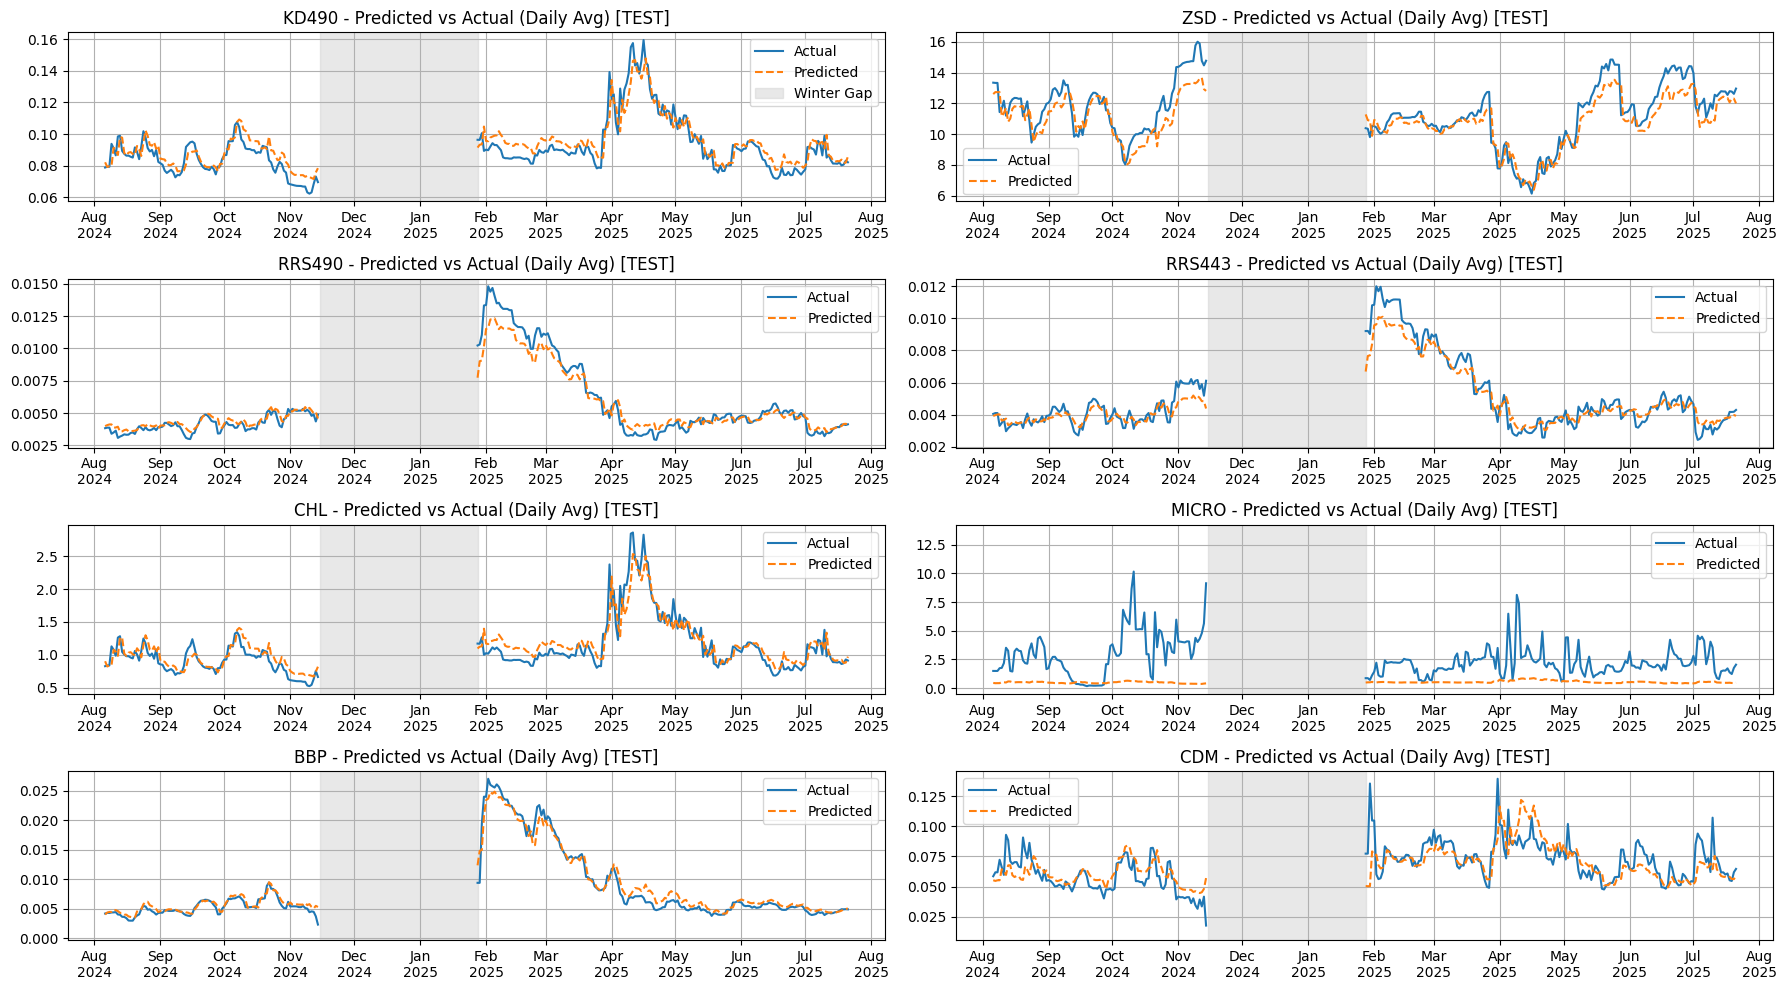

In [ ]:

# Daily spatial means plot (TEST) with winter gaps (broken lines)

pred_means_test = test_pred_unscaled.mean(axis=1)  # [Ttest, F]
true_means_test = test_true_unscaled.mean(axis=1)
test_dates_seq = test_dates[seq_len: seq_len + len(pred_means_test)]

# Define winter date ranges (as datetime objects)
winter_gaps = [
    (pd.to_datetime("2024-11-15"), pd.to_datetime("2025-01-28")),
    # Add more if needed
]

# Convert test_dates_seq to numpy array for masking
test_dates_num = mdates.date2num(test_dates_seq)

fig, axs = plt.subplots(4, 2, figsize=(18, 10))
axs = axs.flatten()

for i, var in enumerate(features):
    # Mask winter gaps
    mask = np.ones(len(test_dates_seq), dtype=bool)
    for start, end in winter_gaps:
        mask &= ((test_dates_seq < start) | (test_dates_seq > end))

    # Split data into continuous segments
    segments = np.where(~mask)[0]
    if len(segments) > 0:
        # Identify start/end indices of gaps
        gap_edges = np.split(np.arange(len(test_dates_seq)), segments)

        # Plot each continuous segment separately
        for seg in gap_edges:
            if len(seg) > 0:  # Skip empty segments
                axs[i].plot(
                    test_dates_seq[seg],
                    true_means_test[seg, i],
                    color='C0', label="Actual" if seg[0] == 0 else ""
                )
                axs[i].plot(
                    test_dates_seq[seg],
                    pred_means_test[seg, i],
                    linestyle="--", color='C1',
                    label="Predicted" if seg[0] == 0 else ""
                )

    axs[i].set_title(f"{var} - Predicted vs Actual (Daily Avg) [TEST]")
    axs[i].xaxis.set_major_locator(mdates.MonthLocator())
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axs[i].grid(True)

    # Shade winter gaps (optional)
    for start, end in winter_gaps:
        axs[i].axvspan(start, end, color="lightgrey", alpha=0.5, label="Winter Gap" if i == 0 else "")

    axs[i].legend()

plt.tight_layout()
plt.show()